# Shift a source mesh to form a target mesh using 3D loss functions

In [1]:
import os
import torch
import pytorch3d
from pytorch3d.transforms import Transform3d, random_rotation
from pytorch3d.io import load_obj, save_obj
from pytorch3d.structures import Meshes
from pytorch3d.utils import ico_sphere
from pytorch3d.ops import sample_points_from_meshes
from pytorch3d.loss import (
    chamfer_distance, 
    mesh_edge_loss, 
    mesh_laplacian_smoothing, 
    mesh_normal_consistency,
)
import numpy as np
from tqdm.notebook import tqdm
%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 80
mpl.rcParams['figure.dpi'] = 80

# Set the device
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
    print("WARNING: CPU only, this will be slow!")

#### 1. Load an obj file and create a Meshes object

Download the target 3D model of a dolphin. It will be saved locally as a file called `dolphin.obj`.

In [ ]:
# !wget https://dl.fbaipublicfiles.com/pytorch3d/data/dolphin/dolphin.obj

In [2]:
# initial
obj_mesh = 'dolphin.obj'
verts, faces, aux = load_obj(obj_mesh)
faces_idx = faces.verts_idx.to(device)
verts = verts.to(device)

center = verts.mean(0)
verts = verts - center
scale = max(verts.abs().max(0)[0])
verts = verts / scale
default_mesh = Meshes(verts=[verts], faces=[faces_idx])

# source
src_scale = torch.tensor(1.0, dtype=torch.float32, device=device)
src_rot = torch.eye(3, dtype=torch.float32, device=device)
src_trans = torch.zeros((1, 3), dtype=torch.float32, device=device)

src_transform = Transform3d(device=device).scale(src_scale).rotate(src_rot).translate(src_trans)
src_verts = src_transform.transform_points(verts)
src_mesh = Meshes(verts=[src_verts], faces=[faces_idx])

# target
trg_scale = torch.tensor(1.5, dtype=torch.float32, device=device)
trg_rot = random_rotation().to(device)
#trg_rot = torch.eye(3, dtype=torch.float32, device=device)
trg_trans = np.array([-2.0, 1.5, 0.0]).reshape(1, 3)
trg_trans = torch.tensor(trg_trans, dtype=torch.float32, device=device)

trg_transform = Transform3d(device=device).scale(trg_scale).rotate(trg_rot).translate(trg_trans)
trg_verts = trg_transform.transform_points(verts)
trg_mesh = Meshes(verts=[trg_verts], faces=[faces_idx])

An exception occurred in telemetry logging.Disabling telemetry to prevent further exceptions.
Traceback (most recent call last):
  File "/home/jonathan/miniconda3/envs/warp/lib/python3.10/site-packages/iopath/common/file_io.py", line 946, in __log_tmetry_keys
    handler.log_event()
  File "/home/jonathan/miniconda3/envs/warp/lib/python3.10/site-packages/iopath/common/event_logger.py", line 97, in log_event
    del self._evt
AttributeError: _evt
/home/jonathan/miniconda3/envs/warp/lib/python3.10/site-packages/pytorch3d/io/obj_io.py:544: UserWarning: No mtl file provided
  warnings.warn("No mtl file provided")


## 2. Visualize the source and target meshes

In [3]:
def plot_pointcloud(mesh, title=""):
    # Sample points uniformly from the surface of the mesh.
    points = sample_points_from_meshes(mesh, 5000)
    x, y, z = points.detach().clone().cpu().squeeze().unbind(1)    
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter3D(x, z, -y)
    ax.set_xlabel('x')
    ax.set_ylabel('z')
    ax.set_zlabel('y')
    ax.set_xlim([-3, 3])
    ax.set_ylim([-3, 3])
    ax.set_zlim([-3, 3])
    ax.set_title(title)
    ax.view_init(190, 30)
    plt.show()

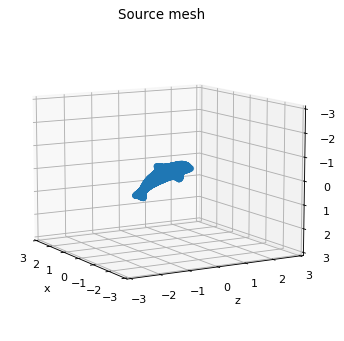

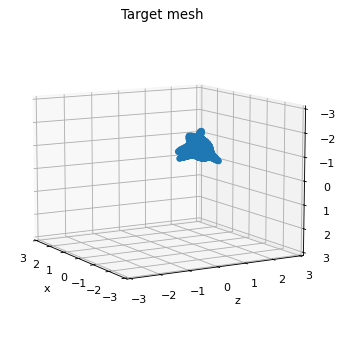

In [4]:
plot_pointcloud(src_mesh, "Source mesh")
plot_pointcloud(trg_mesh, "Target mesh")

## 3. Optimization loop 

In [5]:
optim_scale = src_scale.clone().detach().requires_grad_(True)
optim_axis_angle = torch.zeros((1, 3), dtype=torch.float32, device=device, requires_grad=True)
optim_rot = pytorch3d.transforms.axis_angle_to_matrix(optim_axis_angle)
optim_trans = src_trans.detach().clone().requires_grad_(True)
optim_transform = Transform3d(device=device).scale(optim_scale).rotate(optim_rot).translate(optim_trans)

optimizer = torch.optim.SGD([optim_scale, optim_axis_angle, optim_trans], lr=0.01, momentum=0.9)

#optim_trans = np.array([0.0, 0.0, 0.0]).reshape(1, 3)
#optim_trans = torch.tensor(optim_trans, dtype=torch.float32, requires_grad=True, device=device)
#optim_transform = Transform3d(device=device).translate(optim_trans)
#optimizer = torch.optim.SGD([optim_trans], lr=0.01, momentum=0.9)

  0%|          | 0/2000 [00:00<?, ?it/s]

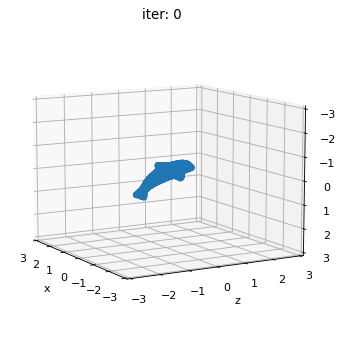

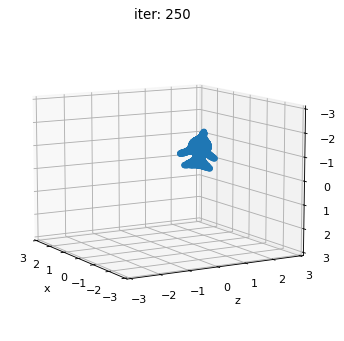

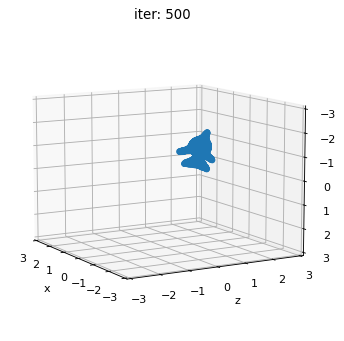

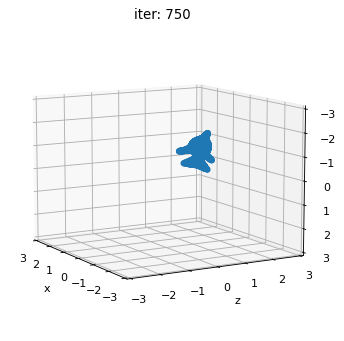

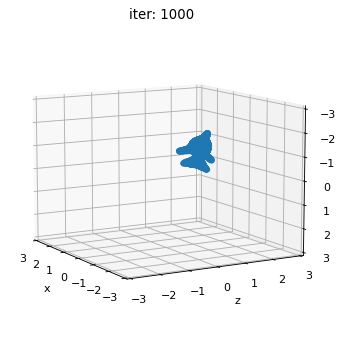

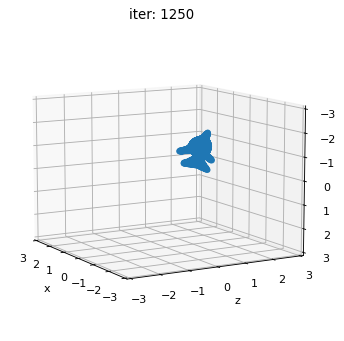

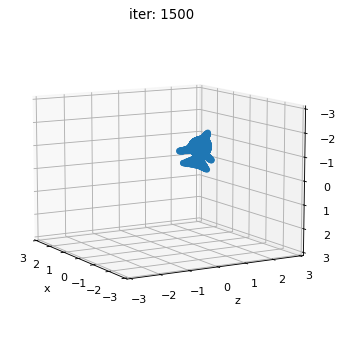

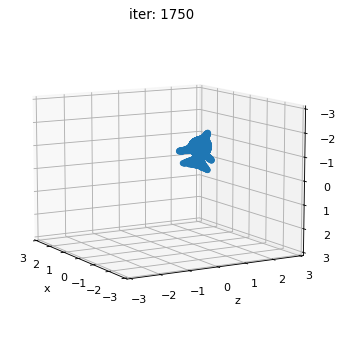

In [8]:
# Number of optimization steps
Niter = 2000
# Weight for the chamfer loss
w_chamfer = 1.0 
# Weight for mesh edge loss
w_edge = 1.0 
# Weight for mesh normal consistency
w_normal = 0.01 
# Weight for mesh laplacian smoothing
w_laplacian = 0.1 
# Plot period for the losses
plot_period = 250
loop = tqdm(range(Niter))

chamfer_losses = []
laplacian_losses = []
edge_losses = []
normal_losses = []

for i in loop:
    optimizer.zero_grad()

    optim_rot = pytorch3d.transforms.axis_angle_to_matrix(optim_axis_angle)
    optim_transform = Transform3d(device=device).scale(optim_scale).rotate(optim_rot).translate(optim_trans)
    optim_verts = optim_transform.transform_points(src_verts)
    optim_verts_batch = optim_verts.reshape(1, -1, 3)
    #optim_mesh = Meshes(verts=[optim_verts], faces=[faces_idx])
   
    # we sample 5k points from the surface of each mesh 
    #sample_optim = sample_points_from_meshes(optim_mesh, 5000)
    #sample_trg = sample_points_from_meshes(trg_mesh, 5000)
 
    # we compare the two sets of pointclouds by computing (a) the chamfer loss
    loss_chamfer, _ = chamfer_distance(trg_verts.reshape(1, -1, 3), optim_verts_batch)
    
    # and (b) the edge length of the predicted mesh
    #loss_edge = mesh_edge_loss(new_src_mesh)
    
    # mesh normal consistency
    #loss_normal = mesh_normal_consistency(new_src_mesh)
    
    # mesh laplacian smoothing
    #loss_laplacian = mesh_laplacian_smoothing(new_src_mesh, method="uniform")
    
    # Weighted sum of the losses
    # loss = loss_chamfer * w_chamfer + loss_edge * w_edge + loss_normal * w_normal + loss_laplacian * w_laplacian
    loss = loss_chamfer * w_chamfer

    # Print the losses
    loop.set_description('total_loss = %.6f' % loss)
    
    # Save the losses for plotting
    chamfer_losses.append(float(loss_chamfer.detach().cpu()))
    #edge_losses.append(float(loss_edge.detach().cpu()))
    #normal_losses.append(float(loss_normal.detach().cpu()))
    #laplacian_losses.append(float(loss_laplacian.detach().cpu()))
    
    # Plot mesh
    if i % plot_period == 0:
        optim_mesh = Meshes(verts=[optim_verts], faces=[faces_idx])
        plot_pointcloud(optim_mesh, title="iter: %d" % i)
        
    # Optimization step
    loss.backward()
    optimizer.step()


In [9]:
print(optim_scale)
print(optim_trans)
print(optim_rot)

tensor(1.4270, device='cuda:0', requires_grad=True)
tensor([[-1.9949,  1.4735,  0.0132]], device='cuda:0', requires_grad=True)
tensor([[[ 0.4861,  0.3504, -0.8006],
         [ 0.2608,  0.8162,  0.5156],
         [ 0.8341, -0.4594,  0.3054]]], device='cuda:0',
       grad_fn=<ReshapeAliasBackward0>)


In [10]:
print(trg_scale)
print(trg_trans)
print(trg_rot)

tensor(1.5000, device='cuda:0')
tensor([[-2.0000,  1.5000,  0.0000]], device='cuda:0')
tensor([[-0.3198,  0.7712,  0.5505],
        [ 0.0348, -0.5710,  0.8202],
        [ 0.9469,  0.2814,  0.1558]], device='cuda:0')


## 4. Visualize the loss

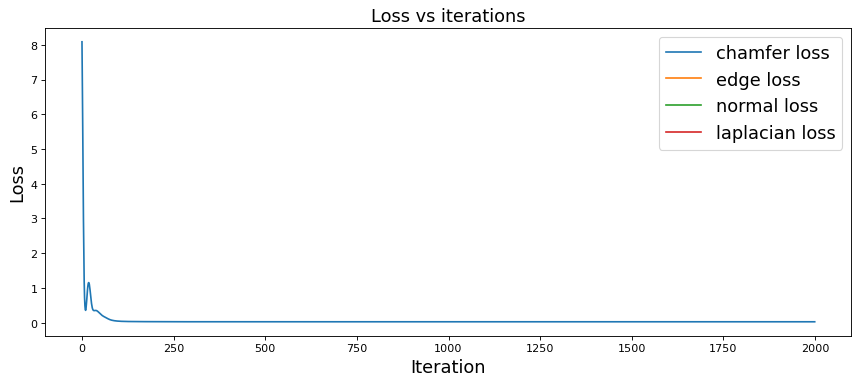

In [13]:
fig = plt.figure(figsize=(13, 5))
ax = fig.gca()
ax.plot(chamfer_losses, label="chamfer loss")
ax.plot(edge_losses, label="edge loss")
ax.plot(normal_losses, label="normal loss")
ax.plot(laplacian_losses, label="laplacian loss")
ax.legend(fontsize="16")
ax.set_xlabel("Iteration", fontsize="16")
ax.set_ylabel("Loss", fontsize="16")
ax.set_title("Loss vs iterations", fontsize="16");

## 5. Save the predicted mesh

In [ ]:
# Fetch the verts and faces of the final predicted mesh
final_verts, final_faces = new_src_mesh.get_mesh_verts_faces(0)

# Scale normalize back to the original target size
final_verts = final_verts * scale + center

# Store the predicted mesh using save_obj
final_obj = 'final_model.obj'
save_obj(final_obj, final_verts, final_faces)

## 6. Conclusion 

In this tutorial we learnt how to load a mesh from an obj file, initialize a PyTorch3D datastructure called **Meshes**, set up an optimization loop and use four different PyTorch3D mesh loss functions. 